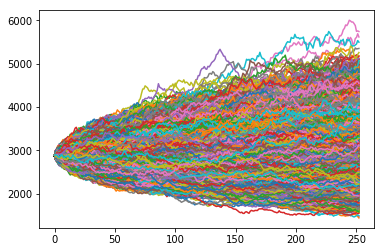

In [1385]:
#plt.plot(x)
#plt.show()

In [1]:
import numpy as np
import pandas as pd
import timeit
import numba
import math

import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns # data visualization Library 

from scipy import stats
from scipy.stats import moment, skew, kurtosis

%matplotlib inline


np.random.seed(1)

In [3]:
# Closed-Form Lookback Function
def lookback_Analytic(S,K,r,q,sigma,T,flavor = 'fixed strike call',t=0):
    dt = T-t
    d1 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d1_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d2_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    
    euro_call = S*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
    euro_put = K*np.exp(-r*dt)*norm.cdf(d2_) - S*np.exp(-q*dt)*norm.cdf(d1_)
    
    lookback1 = np.exp(-r*dt)*(sigma*sigma/(2*r))*S
    lookback_c = (np.exp(r*dt)*norm.cdf(d1) - (np.power((S/K),(-(2*r)/(sigma*sigma))))*norm.cdf(d1-(((2*r)/(sigma))*np.sqrt(dt))))
    lookback_p = (np.power((S/K),(-(2*r)/(sigma*sigma))))*norm.cdf(-d1+(((2*r)/(sigma))*np.sqrt(dt)))-(np.exp(r*dt)*norm.cdf(-d1))
    
    if flavor == 'fixed strike call':
        price =  euro_call + lookback1*lookback_c
        delta = (1 + ((sigma*sigma) / (2*r)))*norm.cdf(d1) + (1 - ((sigma*sigma) / (2*r)))*np.exp(-r*dt)*(np.power(S,(-(2*r)/(sigma**2)))*norm.cdf(d1_))
        rho_q = -dt*S*np.exp(-q*T)*norm.cdf(d1)
    if flavor == 'fixed strike put':
        price = euro_put + lookback1*(lookback_p)
    
    
    return price, delta, rho_q


In [4]:
# Black-Scholes European Pricer
def BS(S,K,r,q,sigma,T,flavor='c',style='euro',display='no',t=0):
    dt = T-t
    d1 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d1_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d2_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    if flavor == 'c':
        price = S*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
        delta = np.exp(-q*dt)*norm.cdf(d1)
        gamma = np.exp(-q*dt)*(1/(S*sigma*np.sqrt(dt)))*norm.pdf(d1)
        vega = S*np.exp(-q*dt)*np.sqrt(dt)*norm.pdf(d1)
        theta = -S*sigma*np.exp(-q*dt)*(1/(2*np.sqrt(dt)))*norm.pdf(d1) +q*S*np.exp(-q*dt)*norm.cdf(d1) - r*K*np.exp(-r*dt)*norm.cdf(d2)
        rho_q = -dt*S*np.exp(-q*T)*norm.cdf(d1)
    if flavor == 'p':
        price = K*np.exp(-r*dt)*norm.cdf(d2_) - S*np.exp(-q*dt)*norm.cdf(d1_)
        delta = -np.exp(-q*dt)*norm.cdf(d1_)
        gamma = np.exp(-q*dt)*(1/(S*sigma*np.sqrt(dt)))*norm.pdf(d1)
        vega = S*np.exp(-q*dt)*np.sqrt(dt)*norm.pdf(d1)
        theta = -S*sigma*np.exp(-q*dt)*(1/(2*np.sqrt(dt)))*norm.pdf(d1) -q*S*np.exp(-q*dt)*norm.cdf(d1_) + r*K*np.exp(-r*dt)*norm.cdf(d2_)
    if display == "yes":
        print("Price: {:.4f}".format(price))
        print("Delta: {:.4f}".format(delta))
        print("Gamma: {:.4f}".format(gamma))
        print("Vega: {:.4f}".format(vega))
        print("Theta: {:.4f}".format(theta))
    return price, delta, gamma, vega, theta, rho_q

In [5]:
# run formulas over specified range
krange = np.linspace(1.0,1.3,100)
krange_inf = np.linspace(0.01,3,100)
n = 100000
S = 2885
K = S*krange
Kinf = S*krange_inf
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
results = []
resultsI = []
resultsBS = []
resultsBSI = []

for k in K:
    results.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call')[0])
    resultsBS.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0])
for k in Kinf:
    resultsI.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call')[0])
    resultsBSI.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0])


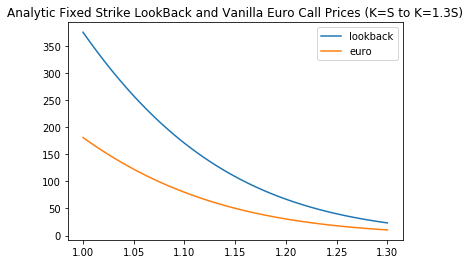

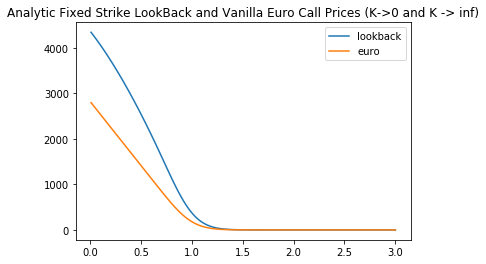

In [6]:
# plot analytic solution vs K for 1.0 <= (K/So) <= 1.3
plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call Prices (K=S to K=1.3S)")
plt.plot(krange,results,krange,resultsBS)
plt.legend(['lookback','euro'])
plt.show()

plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call Prices (K->0 and K -> inf)")
plt.plot(krange_inf,resultsI,krange_inf,resultsBSI)
plt.legend(['lookback','euro'])
plt.show()

In [7]:
# price ATM lookback fixed strike and vanilla euro calls

S = 2885
K = 2885
r = .023
q = .0198
sigma = 0.157
T = 1

LBatm = lookback_Analytic(S,K,r,q,sigma,T,'fixed strike call')[0]
ECatm = BS(S,K,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0]

print('Value of ATM fixed strike lookback call: {:.2f}'.format(LBatm))
print('Value of ATM vanilla euro call: {:.2f}'.format(ECatm))
print('Ratio of lookback to vanilla: {:.2f}'.format(LBatm/ECatm))

Value of ATM fixed strike lookback call: 375.97
Value of ATM vanilla euro call: 181.25
Ratio of lookback to vanilla: 2.07


In [8]:
# Lookback Option Monte Carlo Function
def lookback_MC(batches, freqs, S,K,r,q,sigma,T,flavor='c',style='float',display='no',t=0,antithetic='no'):
    '''This function generate batches of n normally distributed random variables, which are used to generate 
    a geometric brownian motion along m sample paths.  Then we calculate the maximum values, for each batch, along
    each m paths for the specified frequency of m.  We end up with a row vector of n maximums, which are then
    used to calculate the payoff.  We take the mean of each of these, and discount to the present value.'''
    
    num_steps = 252
    dt = T/num_steps
        
    payout = np.zeros(num_steps)
    payoutLookback = []
    payoutLookback_anti = []
    lookbackMean = []
    lookbackVariance = []
    PV = []
    Smax = []
    Smax_ = []
    Smin_ = []
    Smin = []
    
    if antithetic == 'yes':
        np.random.seed(1)
        batches = batches//2
    
        ST = np.zeros((num_steps+1,batches))
        ST_ = np.zeros((num_steps+1,batches))
    
        ST[0,:] = S
        ST_[0,:] = S
        
        for i in range(0,num_steps):
        
            mu = (r - q - sigma*sigma*0.5)*dt
            draws = np.random.normal(size=batches)
            stoch = sigma*np.sqrt(dt)*draws
            stoch1 = np.concatenate((stoch, -stoch)) ## This method for antithetic variates was written by Vinicio De Sola ##
            
            ST[i+1,:] = ST[i,:]*np.exp(mu + stoch)
            ST_[i+1,:] = ST[i,:]*np.exp(mu - stoch)
            
            payout[i] = np.average(np.maximum((ST[i,:] - K),0))
   

        for m in freqs:
            Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))
            Smax_.append(np.max(ST_[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))
            Smin.append(np.min(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))
            Smin_.append(np.min(ST_[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))

        for i in range(0,num_steps):
            PV.append(np.exp(-r*T)*payout[i])
    
    
        for i in range(0,len(freqs)):
            #payoutLookback.append(np.exp(-r*T)*np.maximum((Smax[i] - K),0))
            payoutLookback.append(np.exp(-r*T)*np.mean([np.maximum((Smax[i] - K),0),np.maximum((Smax_[i] - K),0)],axis=0))
            lookbackVariance.append(np.std(payoutLookback[i])/(freqs[i]))
            lookbackMean.append(np.mean(payoutLookback[i]))


        return lookbackMean,lookbackVariance/np.sqrt(batches*2)



    else:
    
        ST = np.zeros((num_steps+1,batches))
        ST_ = np.zeros((num_steps+1,batches))
    
        ST[0,:] = S
        ST_[0,:] = S
        
        for i in range(0,num_steps):   
            mu = (r - q - sigma*sigma*0.5)*dt
            draws = np.random.normal(size=batches)
            stoch = sigma*np.sqrt(dt)*draws
            
            ST[i+1,:] = ST[i,:]*np.exp(mu + stoch)
            
            
            payout[i] = np.average(np.maximum((ST[i,:] - K),0))
    
        for m in freqs:
            Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))
            Smin.append(np.min(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))

        for i in range(0,num_steps):
            PV.append(np.exp(-r*T)*payout[i])
    
    
        for i in range(0,len(freqs)):
            payoutLookback.append(np.exp(-r*T)*np.maximum((Smax[i] - K),0))
            lookbackVariance.append(np.std(payoutLookback[i])/freqs[i])
            lookbackMean.append(np.mean(payoutLookback[i]))
   
        return lookbackMean,lookbackVariance/np.sqrt(batches)


In [12]:
# Define parameters and run simulations for each strike
n = 100000
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
y = .0198
sigma = 0.157
T = 1
dt = T/252
results = []
resultsCF = []
resultsBS = []

for k in K:
    results.append(lookback_MC(n,[1,2,4,12,52,252],S,k,r,q,sigma,T))
    resultsCF.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call'))
    resultsBS.append(BS(S,k,r,q,sigma,T)[0])


In [13]:
# pull values
K_0 = lookback_MC(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T)
K_1 = lookback_MC(n,[1,2,4,12,52,252],S,K[1],r,y,sigma,T)
K_2 = lookback_MC(n,[1,2,4,12,52,252],S,K[2],r,y,sigma,T)
K_3 = lookback_MC(n,[1,2,4,12,52,252],S,K[3],r,y,sigma,T)

In [15]:
K_0

([180.61988769078724,
  220.44573259908907,
  256.06075226052224,
  300.4654579548574,
  340.8198286379629,
  357.655419944165],
 array([0.90258947, 0.45916726, 0.23312544, 0.07917972, 0.01858783,
        0.00386104]))

In [14]:
# create a list for charting
k1 = list([K_0[0],K_1[0],K_2[0],K_3[0]])

In [3249]:
# Display Results
df = pd.DataFrame({'MC Price:':K_0[0], 'Std Error':K_0[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[0])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[0][0])

MC Simulation for Fixed Strike Lookback Call (K=S):

               MC Price:  Std Error
maturity     180.211498   0.906547
semi-annual  219.197909   0.460406
quarterly    254.732472   0.233763
monthly      299.274362   0.079464
weekly       339.609151   0.018638
daily        356.528864   0.003872

BS Value for Vanilla Euro Call: 181.24666946316665

Closed-Form Value for Fixed Strike Lookback Call: 375.96895853236117


In [3250]:
# Display Results
df = pd.DataFrame({'MC Price:':K_1[0], 'Std Error':K_1[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.1S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[1])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[1][0])

MC Simulation for Fixed Strike Lookback Call (K=1.1S):

               MC Price:  Std Error
maturity      80.115128   0.619415
semi-annual   92.862135   0.319573
quarterly    106.234686   0.167347
monthly      125.640848   0.059609
weekly       145.806656   0.014635
daily        154.913415   0.003101

BS Value for Vanilla Euro Call: 80.01123537579667

Closed-Form Value for Fixed Strike Lookback Call: 170.78494203193188


In [3251]:
# Display Results
df = pd.DataFrame({'MC Price:':K_2[0], 'Std Error':K_2[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.2S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[2])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[2][0])

MC Simulation for Fixed Strike Lookback Call (K=1.2S):

              MC Price:  Std Error
maturity     30.509039   0.379955
semi-annual  33.240809   0.194244
quarterly    37.659066   0.102505
monthly      45.175560   0.037177
weekly       53.698090   0.009339
daily        57.775870   0.002001

BS Value for Vanilla Euro Call: 30.656053720348666

Closed-Form Value for Fixed Strike Lookback Call: 67.23070314271794


In [3252]:
# Display Results
df = pd.DataFrame({'MC Price:':K_3[0], 'Std Error':K_3[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.3S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[3])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[3][0])

MC Simulation for Fixed Strike Lookback Call (K=1.3S):

              MC Price:  Std Error
maturity     10.099714   0.212570
semi-annual  10.549525   0.107773
quarterly    11.865064   0.056818
monthly      14.295907   0.020702
weekly       17.388647   0.005288
daily        18.906201   0.001140

BS Value for Vanilla Euro Call: 10.390011362679672

Closed-Form Value for Fixed Strike Lookback Call: 23.37001367688092


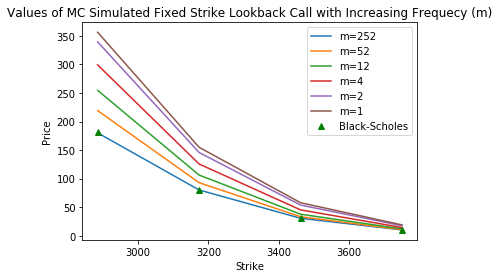

In [3253]:
plt.plot(K,k1, '', K, resultsBS,'g^')
plt.title('Values of MC Simulated Fixed Strike Lookback Call with Increasing Frequecy (m)')
plt.ylabel('Price')
plt.xlabel('Strike')
plt.legend(['m=252', 'm=52', 'm=12', 'm=4', 'm=2', 'm=1', 'Black-Scholes'])
plt.show()

In [3254]:
# set parameters for incrasing n batches and run MC sim
batches = [1000,10000,100000,1000000]
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
results = []
K_0n = []
K_1n = []
K_2n = []
K_3n = []

for n in batches:
    K_0n.append(lookback_MC(n,[12],S,K[0],r,y,sigma,T))
    K_1n.append(lookback_MC(n,[12],S,K[1],r,y,sigma,T))
    K_2n.append(lookback_MC(n,[12],S,K[2],r,y,sigma,T))
    K_3n.append(lookback_MC(n,[12],S,K[3],r,y,sigma,T))


In [3255]:
# create dataframe to display results for various n and k
K0n = pd.DataFrame(K_0n)
K1n = pd.DataFrame(K_1n)
K2n = pd.DataFrame(K_2n)
K3n = pd.DataFrame(K_3n)
K0n.columns = ['MC Price','Std Error']
K0n.index = ['n=1000','n=10000','n=100000','n=1000000']
K1n.columns = ['MC Price','Std Error']
K1n.index = ['n=1000','n=10000','n=100000','n=1000000']
K2n.columns = ['MC Price','Std Error']
K2n.index = ['n=1000','n=10000','n=100000','n=1000000']
K3n.columns = ['MC Price','Std Error']
K3n.index = ['n=1000','n=10000','n=100000','n=1000000']

In [3256]:
# create list for plotting
kn = list([K_0n[0][0],K_0n[1][0],K_0n[2][0],K_0n[3][0]])
kn1 = list([K_1n[0][0],K_1n[1][0],K_1n[2][0],K_1n[3][0]])
kn2 = list([K_2n[0][0],K_2n[1][0],K_2n[2][0],K_2n[3][0]])
kn3 = list([K_3n[0][0],K_3n[1][0],K_3n[2][0],K_3n[3][0]])


In [3257]:
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',K0n)


MC Simulation for Fixed Strike Lookback Call (K=S):

                        MC Price               Std Error
n=1000     [312.67392830809393]    [0.8358884752505631]
n=10000     [305.4066933240677]    [0.2553511241011671]
n=100000    [298.3856480342157]    [0.0794975318169716]
n=1000000   [299.8184484582552]  [0.025104945185427108]


In [3258]:
print('MC Simulation for Fixed Strike Lookback Call (K=1.1S):\n\n',K1n)

MC Simulation for Fixed Strike Lookback Call (K=1.1S):

                        MC Price               Std Error
n=1000     [133.55199809746182]    [0.6254704640863298]
n=10000    [127.21396621383775]   [0.19215188464231514]
n=100000   [126.09389709855456]  [0.059981686401863125]
n=1000000  [125.05331160945593]   [0.01882375183863084]


In [3259]:
print('MC Simulation for Fixed Strike Lookback Call (K=1.2S):\n\n',K2n)

MC Simulation for Fixed Strike Lookback Call (K=1.2S):

                       MC Price               Std Error
n=1000     [52.47634645136226]    [0.4017858513527178]
n=10000      [46.676497349267]   [0.11974498628838491]
n=100000   [45.33021994371444]  [0.037717307418224266]
n=1000000  [45.14756849156632]  [0.011731396433942175]


In [3260]:
print('MC Simulation for Fixed Strike Lookback Call (K=1.3S):\n\n',K3n)

MC Simulation for Fixed Strike Lookback Call (K=1.3S):

                        MC Price               Std Error
n=1000     [14.144193742640905]   [0.22704612646075534]
n=10000    [14.174737843964369]    [0.0665585334768933]
n=100000   [14.448667691469838]  [0.021020459127535637]
n=1000000  [14.587376197884932]  [0.006630695266654947]


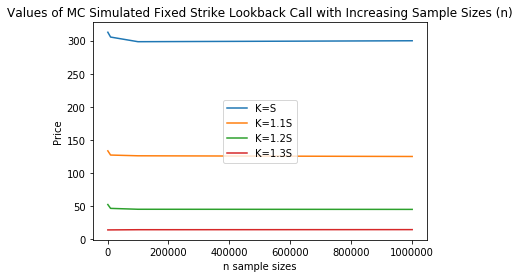

In [3261]:
plt.plot(batches,kn, batches, kn1, batches, kn2, batches, kn3)
plt.title('Values of MC Simulated Fixed Strike Lookback Call with Increasing Sample Sizes (n)')
plt.ylabel('Price')
plt.xlabel('n sample sizes')
plt.legend(['K=S', 'K=1.1S', 'K=1.2S', 'K=1.3S'],loc=10)
plt.show()

In [3262]:
# run formulas over specified range
krange = np.linspace(1.0,1.3,100)
krange_inf = np.linspace(0.01,3,100)
n = 10000
S = 2885
K = S*krange
Kinf = S*krange_inf
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
dresults = []
dresultsMC = []
dresultsI = []
dresultsBS = []
dresultsBSI = []

rresults = []
rresultsI = []
rresultsBS = []
rresultsBSI = []

for k in K:
    dresultsMC.append(lookback_MC(n,[12],S,k,r,y,sigma,T)[0])
    dresults.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call')[1])
    dresultsBS.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[1])
    rresults.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call')[2])
    rresultsBS.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[5])
for k in Kinf:
    dresultsI.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call')[1])
    dresultsBSI.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[1])
    rresultsI.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call')[2])
    rresultsBSI.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[5])



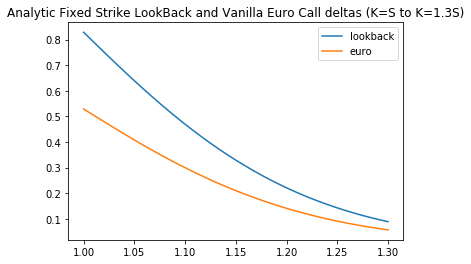

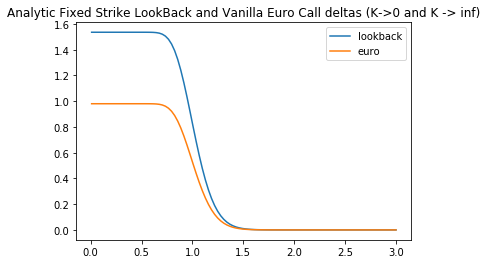

In [3263]:
# plot analytic solution vs K for 1.0 <= (K/So) <= 1.3
plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call deltas (K=S to K=1.3S)")
plt.plot(krange,dresults,krange,dresultsBS)
plt.legend(['lookback','euro'])
plt.show()

plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call deltas (K->0 and K -> inf)")
plt.plot(krange_inf,dresultsI,krange_inf,dresultsBSI)
plt.legend(['lookback','euro'])
plt.show()

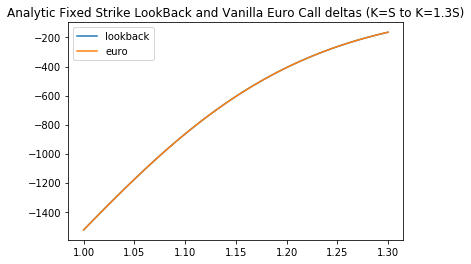

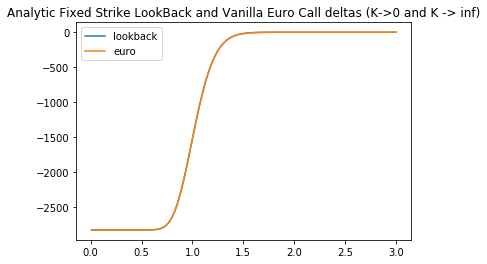

In [3264]:
# plot analytic solution vs K for 1.0 <= (K/So) <= 1.3
plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call deltas (K=S to K=1.3S)")
plt.plot(krange,rresults,krange,rresultsBS)
plt.legend(['lookback','euro'])
plt.show()

plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call deltas (K->0 and K -> inf)")
plt.plot(krange_inf,rresultsI,krange_inf,rresultsBSI)
plt.legend(['lookback','euro'])
plt.show()

In [3265]:
def fdm_delta_centered(epsilon, S0_arr, pricing_func):
    delta_arr = [] # = np.zeros_like(S0_arr)
    for i in range(len(S0_arr)):
        opt_plus = pricing_func(S0_arr[i]*(1+epsilon))
        opt_minus = pricing_func(S0_arr[i]*(1-epsilon))
        delta_arr.append((opt_plus - opt_minus) / (2*epsilon*S0_arr[i]))
    return delta_arr

def fdm_rhoY(epsilon, S0_arr, pricing_func):
    rhoY_arr = np.zeros_like(S0_arr)
    for i in range(len(S0_arr)):
        opt = pricing_func(S0_arr[i])
        opt_plus = pricing_func(S0_arr[i]*(1+epsilon))
        opt_minus = pricing_func(S0_arr[i]*(1-epsilon))
        rhoY_arr[i] = (opt_plus - opt_minus) / (2*epsilon*S0_arr_rhoY[i])
    return gamma_arr

In [3266]:
def plot_sensitivities(epsilon, S0_arr, pricing_func, true_delta, true_gamma):
    
    d_cent = fdm_delta_centered(epsilon, S0_arr, pricing_func)
    plt.subplot(211)
    plt.plot(S0_arr,d_plus, S0_arr,d_minus,S0_arr,d_cent, S0_arr,true_delta)
    
    plt.subplot(212)    
    g = fdm_rhoY(epsilon, S0_arr, pricing_func)
    plt.plot(S0_arr, g, S0_arr,true_gamma)
    plt.show()
    return

In [3272]:
# Define parameters and run simulations for each strike
n = 100000
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
results_a = []
resultsCF = []
resultsBS = []

for k in K:
    results_a.append(lookback_MC(n,[1,2,4,12,52,252],S,k,r,y,sigma,T,antithetic='yes'))
    resultsCF.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call'))
    resultsBS.append(BS(S,k,r,q,sigma,T)[0])

In [3273]:
# pull values
K_0a = lookback_MC(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T,antithetic='yes')
K_1a = lookback_MC(n,[1,2,4,12,52,252],S,K[1],r,y,sigma,T,antithetic='yes')
K_2a = lookback_MC(n,[1,2,4,12,52,252],S,K[2],r,y,sigma,T,antithetic='yes')
K_3a = lookback_MC(n,[1,2,4,12,52,252],S,K[3],r,y,sigma,T,antithetic='yes')

In [3274]:
K_0a = lookback_MC(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T,antithetic='yes')
K_0b = lookback_MC(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T,antithetic='no')

In [3275]:
K_0a

([181.30539791765358,
  220.5551700137553,
  257.2325014622021,
  304.21164164786705,
  352.20897794328687,
  378.43125467538505],
 array([0.90452323, 0.45808476, 0.23255243, 0.07930965, 0.01862931,
        0.00388264]))

In [3276]:
K_0b

([180.52056015851556,
  220.14411584711223,
  256.1468090883943,
  300.77319263238917,
  340.9970000917513,
  357.83095060805095],
 array([0.91063169, 0.46258576, 0.2346233 , 0.07973417, 0.0186818 ,
        0.00388053]))

In [3277]:
# create a list for charting
k1 = list([K_0[0],K_1[0],K_2[0],K_3[0]])
k1se = list([K_0[1],K_1[1],K_2[1],K_3[1]])
k1A = list([K_0a[0],K_1a[0],K_2a[0],K_3a[0]])
k1seA = list([K_0a[1],K_1a[1],K_2a[1],K_3a[1]])
k1seA

[array([0.90452323, 0.45808476, 0.23255243, 0.07930965, 0.01862931,
        0.00388264]),
 array([0.61482261, 0.31620452, 0.16577037, 0.05956268, 0.01481847,
        0.00318508]),
 array([0.37616302, 0.19193734, 0.10131463, 0.03719708, 0.00951993,
        0.00208415]),
 array([0.2118434 , 0.10700022, 0.0562103 , 0.02090978, 0.00545715,
        0.00121252])]

In [3278]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_0a[0], 'Std Error':K_0a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[0])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[0][0])

MC Simulation for Fixed Strike Lookback Call (K=S):

               MC Price:  Std Error
maturity     181.305398   0.904523
semi-annual  220.555170   0.458085
quarterly    257.232501   0.232552
monthly      304.211642   0.079310
weekly       352.208978   0.018629
daily        378.431255   0.003883

BS Value for Vanilla Euro Call: 181.24666946316665

Closed-Form Value for Fixed Strike Lookback Call: 375.96895853236117


In [3279]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_1a[0], 'Std Error':K_1a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.1S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[1])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[1][0])

MC Simulation for Fixed Strike Lookback Call (K=1.1S):

               MC Price:  Std Error
maturity      79.972881   0.614823
semi-annual   92.310779   0.316205
quarterly    106.009881   0.165770
monthly      127.232401   0.059563
weekly       151.460644   0.014818
daily        166.020148   0.003185

BS Value for Vanilla Euro Call: 80.01123537579667

Closed-Form Value for Fixed Strike Lookback Call: 170.78494203193188


In [3280]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_2a[0], 'Std Error':K_2a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.2S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[2])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[2][0])

MC Simulation for Fixed Strike Lookback Call (K=1.2S):

              MC Price:  Std Error
maturity     30.515281   0.376163
semi-annual  33.060685   0.191937
quarterly    37.636635   0.101315
monthly      45.929186   0.037197
weekly       56.308363   0.009520
daily        62.988478   0.002084

BS Value for Vanilla Euro Call: 30.656053720348666

Closed-Form Value for Fixed Strike Lookback Call: 67.23070314271794


In [3281]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_3a[0], 'Std Error':K_3a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.3S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[3])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[3][0])

MC Simulation for Fixed Strike Lookback Call (K=1.3S):

              MC Price:  Std Error
maturity     10.214439   0.211843
semi-annual  10.613500   0.107000
quarterly    11.944995   0.056210
monthly      14.741751   0.020910
weekly       18.569344   0.005457
daily        21.218732   0.001213

BS Value for Vanilla Euro Call: 10.390011362679672

Closed-Form Value for Fixed Strike Lookback Call: 23.37001367688092


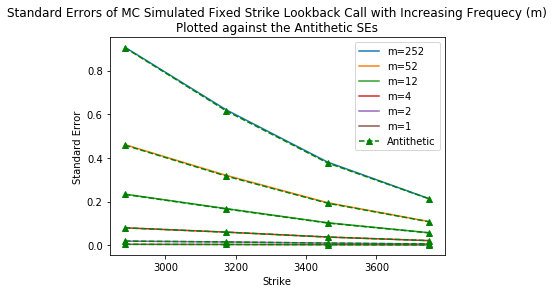

In [3282]:
plt.plot(K,k1se, '', K, k1seA,'g^--')
plt.title('Standard Errors of MC Simulated Fixed Strike Lookback Call with Increasing Frequecy (m)\nPlotted against the Antithetic SEs')
plt.ylabel('Standard Error')
plt.xlabel('Strike')
plt.legend(['m=252', 'm=52', 'm=12', 'm=4', 'm=2', 'm=1', 'Antithetic'])
plt.show()

>We see a slight reduction in standard errors using the antithetic variates method

In [3283]:
# Lookback Option Monte Carlo Function
def lookback_MC_CV_european(batches, freqs, S,K,r,q,sigma,T,CV_val,flavor='c',style='float',display='no',t=0):
    '''This function generate batches of n normally distributed random variables, which are used to generate 
    a geometric brownian motion along m sample paths.  Then we calculate the maximum values, for each batch, along
    each m paths for the specified frequency of m.  We end up with a row vector of n maximums, which are then
    used to calculate the payoff.  We take the mean of each of these, and discount to the present value.'''
    num_steps = 252
    dt = T/num_steps
    
    ST = np.zeros((num_steps+1,batches))
    
    
    Smax = []
    Smin = []
    ST[0,:] = S
    
    
    
    payout = np.zeros(num_steps)
    payoutLookback = []
    lookbackMean = []
    lookbackVariance = []
    PV = []
    
    for i in range(0,num_steps):   
        mu = (r - q - sigma*sigma*0.5)*dt
        draws = np.random.normal(size=batches)
        stoch = sigma*np.sqrt(dt)*draws
    
        ST[i+1,:] = ST[i,:]*np.exp(mu + stoch)

    
    for m in freqs:
        Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],axis=0))


    for i in range(0,len(freqs)):
        payoutLookback = np.exp(-r*T)*np.maximum((Smax[i] - K),0)
        payout_euro = np.exp(-r*T)*(np.maximum(ST[-1,:]-K,0))
        diff = payoutLookback - payout_euro
        CV_adj = np.mean(diff)
        lookbackVariance.append(np.std(diff))
        lookbackMean.append((CV_val + CV_adj))
   
    return lookbackMean,lookbackVariance/np.sqrt(batches)

# Lookback Option Monte Carlo Function
def lookback_MC_CV_bridge(batches, freqs, S,K,r,q,sigma,T,CV_val,flavor='c',style='float',display='no',t=0):
    '''This function generate batches of n normally distributed random variables, which are used to generate 
    a geometric brownian motion along m sample paths.  Then we calculate the maximum values, for each batch, along
    each m paths for the specified frequency of m.  We end up with a row vector of n maximums, which are then
    used to calculate the payoff.  We take the mean of each of these, and discount to the present value.'''
    
    
    num_steps = 252
    dt = T/num_steps
    
    ST = np.zeros((num_steps,batches))
    
    
    Smax = []
    Smin = []
    ST[0,:] = S
    
    
    
    payout = np.zeros(num_steps)
    payoutLookback = []
    lookbackMean = []
    lookbackVariance = []
    PV = []
    
    for i in range(1,num_steps):   
        mu = (r - q - sigma*sigma*0.5)*dt
        draws = np.random.normal(size=batches)
        stoch = sigma*np.sqrt(dt)*draws
    
        ST[i,:] = ST[i-1,:]*np.exp(mu + stoch)

    
    for m in freqs:
        Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],axis=0))


    for i in range(0,len(freqs)):
        m= freqs[i]
        if freqs[i]==1:
            x_t = (ST[-1,:] - ST[0,:])/ST[0,:]  # Normalize for starting at 0
            u = np.random.uniform(size=(batches))
            b_max = (((x_t + np.sqrt(x_t**2-2*sigma**2 * T*np.log(u)))/2)*ST[0,:]) + ST[0,:] # Reverse normalization from above
        
        else:
            temp_ref = list(range(0,252))
            temp_index = temp_ref[int(num_steps/m)-1:num_steps:int(num_steps/m)]
            b_max = np.zeros((len(temp_index),batches))
            for j in range(len(temp_index)):
                x_t = (ST[temp_index[j],:]-ST[temp_index[j-1],:]) / (ST[temp_index[j-1],:])
                u = np.random.uniform(size=(batches))
                b_max[j,:] = (((x_t + np.sqrt(x_t**2-2*sigma**2 * (T/m)*np.log(u)))/2)*ST[temp_index[j-1],:]) + ST[temp_index[j-1],:] # Reverse normalization from above
            
            b_max = np.max(b_max,axis=0)
        payoutLookback = np.exp(-r*T)*np.maximum((Smax[i] - K),0)
        payout_cts = np.exp(-r*T)*(np.maximum(b_max-K,0))
        diff = payout_cts - payoutLookback
        CV_adj = np.mean(diff)
        lookbackVariance.append(np.std(diff))
        lookbackMean.append((CV_val - CV_adj))
   
    return lookbackMean,lookbackVariance/np.sqrt(batches)



In [3288]:
# Define parameters and run simulations for each strike
n = 100000
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
results_a = []
resultsCF = []
resultsBS = []
CV_val = .99

for k in K:
    results_a.append(lookback_MC_CV_european(n,[1,2,4,12,52,252],S,k,r,y,sigma,T,CV_val))
    resultsCF.append(lookback_MC_CV_bridge(n,[1,2,4,12,52,252],S,k,r,y,sigma,T,CV_val))
    resultsBS.append(BS(S,k,r,q,sigma,T)[0])

In [ ]:
# pull values
K_0a = lookback_MC_CV_european(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T,antithetic='yes')
K_1a = lookback_MC(n,[1,2,4,12,52,252],S,K[1],r,y,sigma,T,antithetic='yes')
K_2a = lookback_MC(n,[1,2,4,12,52,252],S,K[2],r,y,sigma,T,antithetic='yes')
K_3a = lookback_MC(n,[1,2,4,12,52,252],S,K[3],r,y,sigma,T,antithetic='yes')

In [3290]:
results_a

[([0.6148782401219728,
   40.204822039182666,
   75.83819663168637,
   120.12048992094044,
   160.26603077424897,
   177.08898672419997],
  array([0.06847143, 0.30806946, 0.38704284, 0.44277592, 0.47018826,
         0.47719423])),
 ([0.6085086444707873,
   13.300160913511863,
   26.71622991161143,
   46.23191888172908,
   66.16762544623391,
   75.36519926304129],
  array([0.05369434, 0.17794984, 0.24206162, 0.30989761, 0.36318466,
         0.3842099 ])),
 ([0.8471359538651628,
   3.6661699284432334,
   8.16723813199243,
   15.541578507300585,
   24.091574617452228,
   28.076963699616407],
  array([0.03755347, 0.08737653, 0.13339867, 0.18237001, 0.22709475,
         0.24554193])),
 ([0.8513490775302869,
   1.3385495486824739,
   2.6361778017060575,
   5.10700617370388,
   8.248240996316001,
   9.807743224117925],
  array([0.02461361, 0.04038183, 0.06762308, 0.09938474, 0.12839898,
         0.14144204]))]

In [3292]:
resultsCF

[([-176.47922857081053,
   -126.75268078686996,
   -97.952549694149,
   -65.41471806172993,
   -37.25843323973566,
   -16.802167011810926],
  array([0.42277091, 0.36669181, 0.25368143, 0.1469585 , 0.06929459,
         0.03000233])),
 ([-65.39596710345043,
   -76.50175097181061,
   -57.34505889569539,
   -37.015299217576995,
   -20.624313265233862,
   -8.84560675408997],
  array([0.31985489, 0.34531805, 0.24963216, 0.15501451, 0.08309546,
         0.03769621])),
 ([-19.449235624807663,
   -34.66645570800687,
   -23.966673301196966,
   -15.605913731891155,
   -8.817937037856439,
   -3.49715921444964],
  array([0.18111628, 0.26180836, 0.18675418, 0.12146984, 0.06755334,
         0.03089804])),
 ([-4.743873680173654,
   -12.467025968704599,
   -7.767905091638143,
   -5.294137700161313,
   -2.8769644074457146,
   -0.8312347604716122],
  array([0.09157037, 0.16804064, 0.11538892, 0.0810011 , 0.04630586,
         0.02171209]))]

> We can see this significantly reduced the standard errors